In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns

In [30]:
bristol_broadband = pd.read_csv("/Users/anukul/Desktop/Anukul/Learning/DataScience/Cleaning/cleaned-data/bristol-broadband-cleaned.csv")
cornwall_broadband = pd.read_csv("/Users/anukul/Desktop/Anukul/Learning/DataScience/Cleaning/cleaned-data/cornwall-broadband-cleaned.csv")

In [31]:
bristol_crime = pd.read_csv("/Users/anukul/Desktop/Anukul/Learning/DataScience/Cleaning/cleaned-data/bristol-crime-cleaned.csv")
cornwall_crime = pd.read_csv("/Users/anukul/Desktop/Anukul/Learning/DataScience/Cleaning/cleaned-data/cornwall-crime-cleaned.csv")

In [32]:
population_2011 = pd.read_csv("/Users/anukul/Desktop/Anukul/Learning/DataScience/Obtaining/population-2011.csv")

In [34]:
population_2011.columns

Index(['Postcode', 'Population'], dtype='object')

In [35]:
# Adjust population data from 2011 to 2023

# Remove special characters (e.g., commas) from the 'Population' column
population_2011['Population'] = population_2011['Population'].replace({',': ''}, regex=True)

# Convert 'Population' column to numeric, forcing errors to NaN
population_2011['Population'] = pd.to_numeric(population_2011['Population'], errors='coerce')

# Check if there are any NaN values and handle them as needed
if population_2011['Population'].isnull().any():
    print("Warning: There are NaN values in the 'Population' column after conversion.")

# Adjust population data from 2011 to 2023
growth_factor = 1.00561255390388033
years_span = 2023 - 2011
growth_rate = growth_factor ** (1 / years_span)
population_2023 = population_2011.copy()
population_2023['Population_2023'] = population_2011['Population'] * growth_factor
population_2022 = population_2023.copy()
population_2022['Population_2022'] = population_2023['Population_2023'] / growth_rate

# Optional: Drop rows with NaN values if necessary
population_2022 = population_2022.dropna(subset=['Population_2022'])

# Display the updated DataFrame to verify the changes
print(population_2022.head())

  Postcode  Population  Population_2023  Population_2022
0   AL1  1        5453      5483.605256      5481.048271
1   AL1  2        6523      6559.610689      6556.551966
2   AL1  3        4179      4202.454863      4200.495273
3   AL1  4        9799      9853.997416      9849.402532
4   AL1  5       10226     10283.393976     10278.598866


In [36]:
# Process crime rate data for Bristol
bristol_crime['Postcode'] = bristol_crime['postcode'].str.extract(r"^(\S+ \d+)")
bristol_crime['Year'] = bristol_crime['Year'].str[:4]

# Process crime rate data for Cornwall
cornwall_crime['Postcode'] = cornwall_crime['postcode'].str.extract(r"^(\S+ \d+)")
cornwall_crime['Year'] = cornwall_crime['Year'].str[:4]

In [39]:
bristol_drug_rates = (
    bristol_crime.query("Year == '2022'")
    .merge(population_2022, left_on='Postcode', right_on='Postcode', how='left')
    .query("Crime_type == 'Drugs' and city == 'Bristol, City of' and Population_2022.notna()")
    .groupby('postcode')
    .agg(Drug_Offenses=('Crime_type', 'size'), Population=('Population_2022', 'first'))
    .reset_index()
    .assign(Drug_Offense_Rate=lambda x: x['Drug_Offenses'] / x['Population'] * 10000)
)

In [40]:
bristol_drug_rates

,postcode,Drug_Offenses,Population,Drug_Offense_Rate
0,BS10 5AF,2,9548.864583,2.094490
1,BS10 5AN,1,9548.864583,1.047245
2,BS10 5BF,8,9548.864583,8.377959
3,BS10 5DG,2,9548.864583,2.094490
4,BS10 5FB,6,9548.864583,6.283470
...,...,...,...,...
82,BS16 2FE,4,9121.678536,4.385158
83,BS16 2NF,4,9121.678536,4.385158
84,BS16 3AX,3,6889.254511,4.354608
85,BS16 3DE,5,6889.254511,7.257679


In [41]:
cornwall_drug_rates = (
    cornwall_crime.query("Year == '2022'")
    .merge(population_2022, left_on='Postcode', right_on='Postcode', how='left')
    .query("Crime_type == 'Drugs' and city == 'Cornwall' and Population_2022.notna()")
    .groupby('postcode')
    .agg(Drug_Offenses=('Crime_type', 'size'), Population=('Population_2022', 'first'))
    .reset_index()
    .assign(Drug_Offense_Rate=lambda x: x['Drug_Offenses'] / x['Population'] * 10000)
)

In [42]:
bristol_broadband.columns

Index(['postcode', 'postcode_space', 'postcode area',
       'Average_download_speed_Mbit_s', 'Maximum_download_speed_Mbit_s',
       'Minimum_download_speed_Mbit_s', 'Average_upload_speed_Mbit_s',
       'Maximum_upload_speed_Mbit_s', 'Minimum_upload_speed_Mbit_s',
       'Average_data_usage_GB', 'All Premises', 'All Matched Premises',
       'lsoa_area', 'county'],
      dtype='object')

In [43]:
bristol_analysis = (
    bristol_broadband
    .merge(bristol_drug_rates, left_on='postcode_space', right_on='postcode', how='inner')
    .loc[:, ['Average_download_speed_Mbit_s', 'Drug_Offense_Rate']]
)

In [45]:
correlation_bristol = bristol_analysis[['Average_download_speed_Mbit_s', 'Drug_Offense_Rate']].corr().iloc[0, 1]
print(f"Correlation for Bristol: {correlation_bristol:.3f}")

Correlation for Bristol: -0.271


In [46]:
import statsmodels.api as sm

In [47]:
X_bristol = sm.add_constant(bristol_analysis['Average_download_speed_Mbit_s'])
model_bristol = sm.OLS(bristol_analysis['Drug_Offense_Rate'], X_bristol).fit()
print(model_bristol.summary())

                            OLS Regression Results                            
Dep. Variable:      Drug_Offense_Rate   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     4.598
Date:                Mon, 19 Aug 2024   Prob (F-statistic):             0.0362
Time:                        19:21:11   Log-Likelihood:                -127.80
No. Observations:                  60   AIC:                             259.6
Df Residuals:                      58   BIC:                             263.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [62]:
sns.set_theme(style="whitegrid")

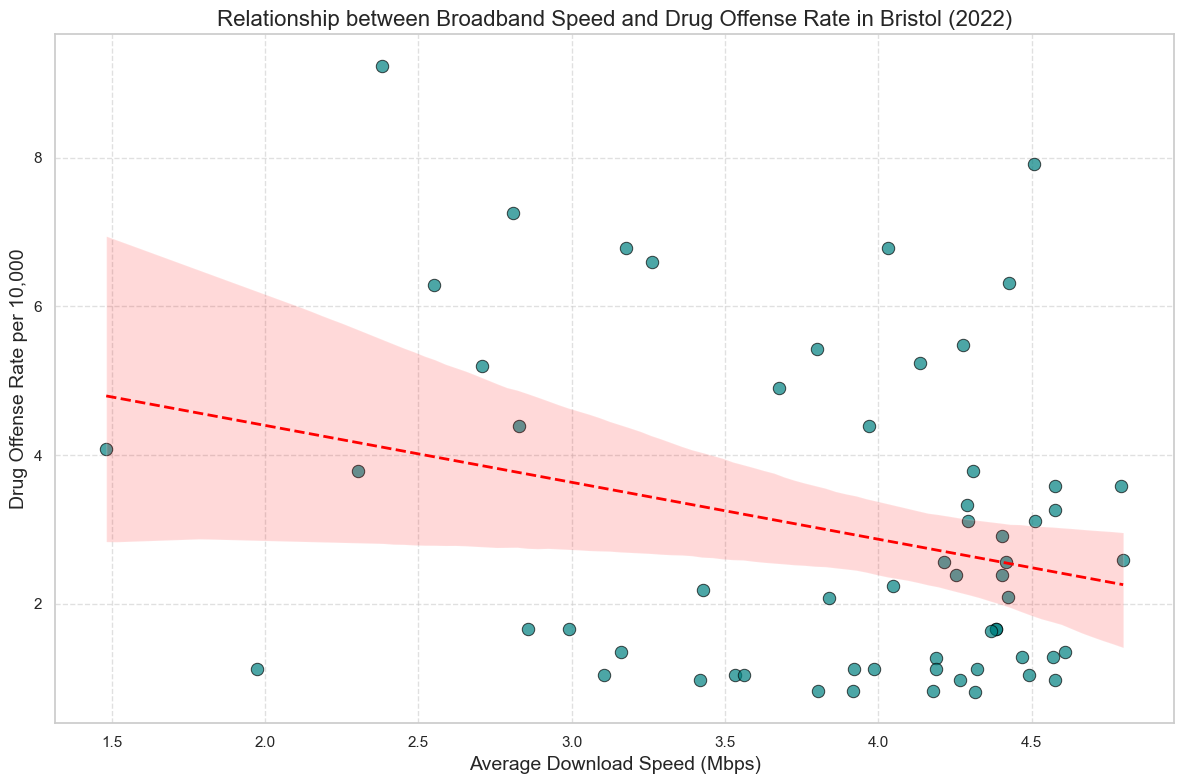

In [66]:
plt.figure(figsize=(12, 8))

sns.scatterplot(
    x='Average_download_speed_Mbit_s', 
    y='Drug_Offense_Rate', 
    data=bristol_analysis, 
    color='teal', 
    s=80, 
    edgecolor='black', 
    alpha=0.7
)
sns.regplot(
    x='Average_download_speed_Mbit_s', 
    y='Drug_Offense_Rate', 
    data=bristol_analysis, 
    scatter=False, 
    color='red', 
    line_kws={"linewidth":2, "linestyle":"--"}
)
plt.title('Relationship between Broadband Speed and Drug Offense Rate in Bristol (2022)', fontsize=16)
plt.xlabel('Average Download Speed (Mbps)', fontsize=14)
plt.ylabel('Drug Offense Rate per 10,000', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [53]:
cornwall_analysis = (
    cornwall_broadband
    .merge(cornwall_drug_rates, left_on='postcode_space', right_on='postcode', how='inner')
    .loc[:, ['Average_download_speed_Mbit_s', 'Drug_Offense_Rate']]
)

In [55]:
correlation_cornwall = cornwall_analysis[['Average_download_speed_Mbit_s', 'Drug_Offense_Rate']].corr().iloc[0, 1]
print(f"Correlation for Cornwall: {correlation_cornwall:.3f}")

Correlation for Cornwall: -0.142


In [57]:
X_cornwall = sm.add_constant(cornwall_analysis['Average_download_speed_Mbit_s'])
model_cornwall = sm.OLS(cornwall_analysis['Drug_Offense_Rate'], X_cornwall).fit()
print(model_cornwall.summary())

                            OLS Regression Results                            
Dep. Variable:      Drug_Offense_Rate   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     2.093
Date:                Mon, 19 Aug 2024   Prob (F-statistic):              0.151
Time:                        19:23:54   Log-Likelihood:                -258.47
No. Observations:                 103   AIC:                             520.9
Df Residuals:                     101   BIC:                             526.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

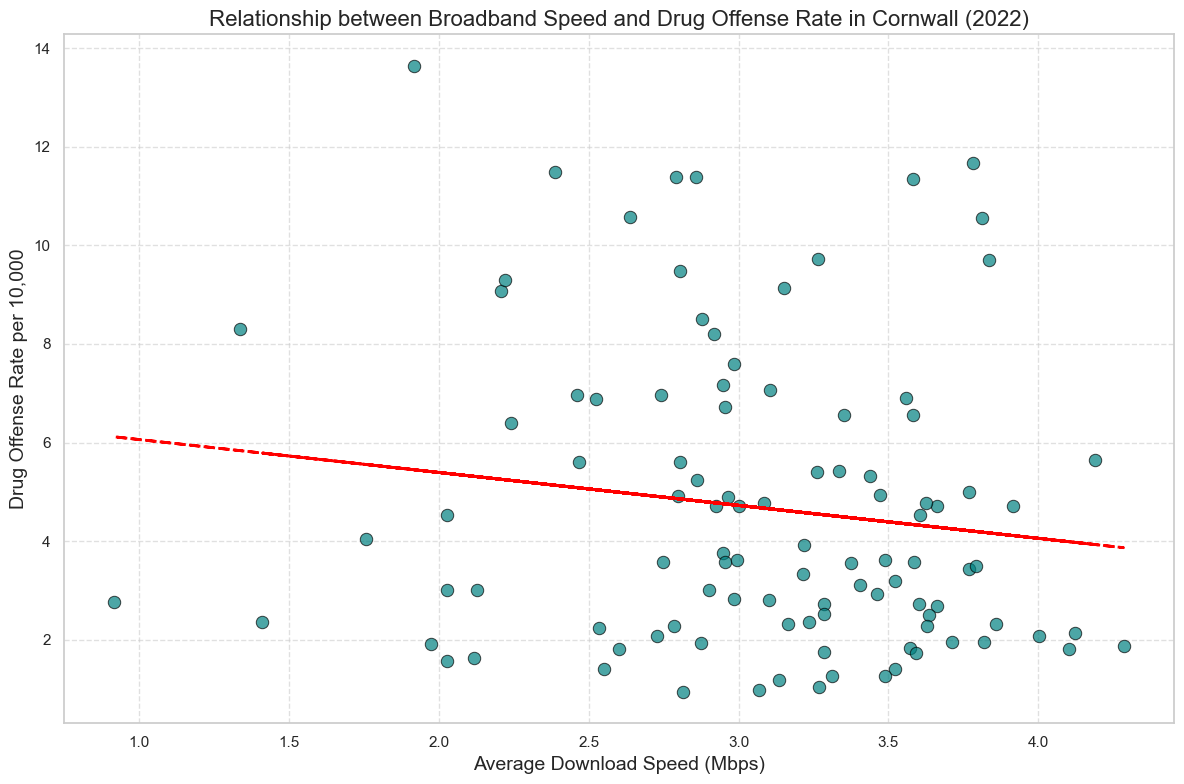

In [65]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='Average_download_speed_Mbit_s', 
    y='Drug_Offense_Rate', 
    data=cornwall_analysis, 
    color='teal', 
    s=80, 
    edgecolor='black', 
    alpha=0.7
)

plt.plot(
    cornwall_analysis['Average_download_speed_Mbit_s'],
    model_cornwall.predict(X_cornwall),
    color='red',
    linewidth=2,
    linestyle='--'  
)

plt.title('Relationship between Broadband Speed and Drug Offense Rate in Cornwall (2022)', fontsize=16)
plt.xlabel('Average Download Speed (Mbps)', fontsize=14)
plt.ylabel('Drug Offense Rate per 10,000', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()